# 音频频响校准系统

本notebook用于:
1. 生成高保真参考音频(20Hz-20kHz扫频)
2. 校准手机麦克风的频响特性
3. 校准扬声器的频响特性

## 依赖库安装
```bash
pip install numpy scipy matplotlib sounddevice soundfile librosa
```

In [2]:
import numpy as np
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
import librosa
import os

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("可用音频设备:")
print(sd.query_devices())

可用音频设备:
  0 BlackHole 2ch, Core Audio (2 in, 2 out)
> 1 MacBook Pro麦克风, Core Audio (1 in, 0 out)
< 2 MacBook Pro扬声器, Core Audio (0 in, 2 out)


## 第一部分: 生成参考音频

生成一个带标识音的高保真扫频信号(20Hz-20kHz),采用等响度曲线补偿

正在生成参考音频...
参考音频已生成: reference_audio.wav
采样率: 96000 Hz
位深度: 32-bit float
总时长: 11.00 秒
扫频时长: 10 秒

扫频起始频率: 20.0 Hz
扫频结束频率: 19999.9 Hz
频率覆盖范围: 20 Hz - 20000 Hz ✓


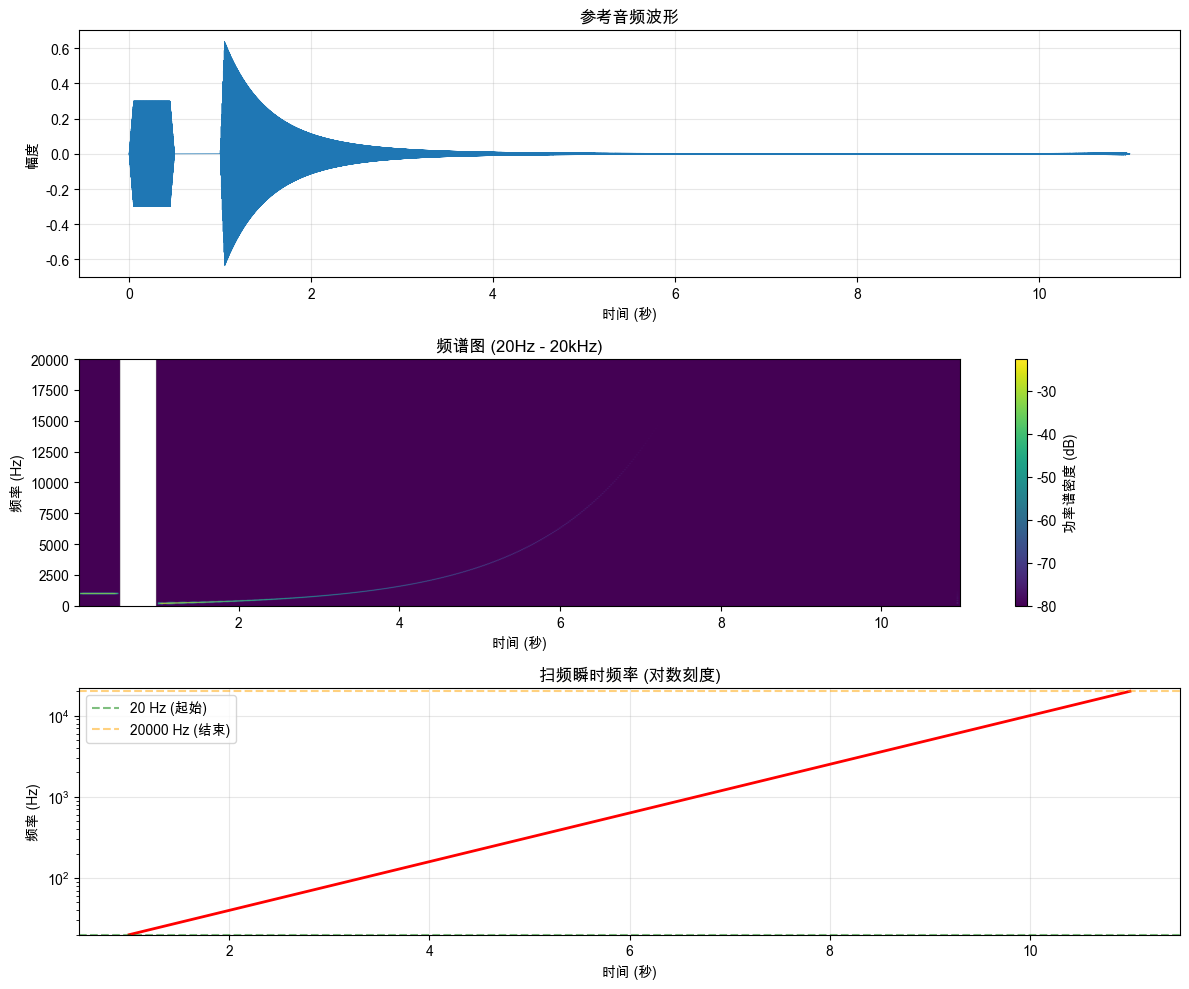


=== 使用说明 ===
1. 使用 MacBook 以最高音量播放此文件
2. 确保音频输出设置为最高质量(系统偏好设置 > 声音)
3. 使用手机录音并保存为 'phone_recording.wav'


In [6]:
# 音频参数设置 - 使用高采样率以获得最佳保真度
SAMPLE_RATE = 96000  # 96kHz 采样率,远高于奈奎斯特频率
BIT_DEPTH = 'FLOAT'  # 使用浮点格式获得最高动态范围

# 频率范围
F_MIN = 20      # 最低频率 20Hz
F_MAX = 20000   # 最高频率 20kHz

# 时间参数
BEEP_DURATION = 0.5    # 标识音持续时间(秒)
BEEP_FREQ = 1000       # 标识音频率 1kHz
SWEEP_DURATION = 10    # 扫频持续时间(秒) - 减少到10秒以更快完成测试
FADE_TIME = 0.05       # 淡入淡出时间(秒)

def generate_beep(duration, freq, sample_rate):
    """生成标识音"""
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    beep = 0.3 * np.sin(2 * np.pi * freq * t)
    
    # 添加淡入淡出避免咔嗒声
    fade_samples = int(FADE_TIME * sample_rate)
    fade_in = np.linspace(0, 1, fade_samples)
    fade_out = np.linspace(1, 0, fade_samples)
    
    beep[:fade_samples] *= fade_in
    beep[-fade_samples:] *= fade_out
    
    return beep

def iso226_spl(freq):
    """简化的ISO 226等响度曲线(近似)
    返回相对于1kHz的响度补偿(dB)
    """
    # 使用简化的A-weighting作为等响度近似
    f = np.atleast_1d(freq)
    f2 = f ** 2
    
    # A-weighting 公式
    ra = (12194 ** 2 * f2 ** 2) / \
         ((f2 + 20.6 ** 2) * np.sqrt((f2 + 107.7 ** 2) * (f2 + 737.9 ** 2)) * (f2 + 12194 ** 2))
    
    a_weight = 20 * np.log10(ra + 1e-10) + 2.00
    
    # 归一化到1kHz为0dB
    f_ref = 1000.0
    f2_ref = f_ref ** 2
    ra_ref = (12194 ** 2 * f2_ref ** 2) / \
             ((f2_ref + 20.6 ** 2) * np.sqrt((f2_ref + 107.7 ** 2) * (f2_ref + 737.9 ** 2)) * (f2_ref + 12194 ** 2))
    ref_weight = 20 * np.log10(ra_ref + 1e-10) + 2.00
    
    result = a_weight - ref_weight
    
    # 如果输入是标量,返回标量
    if np.isscalar(freq):
        return float(result[0])
    return result

def generate_equal_loudness_sweep(f_min, f_max, duration, sample_rate):
    """生成等响度扫频信号(对数扫频)
    
    扫频会在指定的duration时间内精确从f_min扫到f_max后停止
    """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    
    # 对数扫频(在对数频率空间均匀)
    # 瞬时频率: f(t) = f_min * (f_max/f_min)^(t/T)
    k = (f_max / f_min) ** (1 / duration)
    instantaneous_freq = f_min * k ** t
    
    # 相位积分
    phase = 2 * np.pi * f_min * duration / np.log(k) * (k ** t - 1)
    
    # 生成扫频信号
    sweep = np.sin(phase)
    
    # 等响度补偿 - 批量计算所有频率的补偿
    comp_db = -iso226_spl(instantaneous_freq)  # 取负值是为了补偿
    compensation = 10 ** (comp_db / 20)  # 转换为线性增益
    
    # 应用补偿
    sweep_compensated = sweep * compensation
    
    # 归一化到-3dB以留出余量
    sweep_compensated = sweep_compensated / np.max(np.abs(sweep_compensated)) * 0.707
    
    # 添加淡入淡出
    fade_samples = int(FADE_TIME * sample_rate)
    fade_in = np.linspace(0, 1, fade_samples)
    fade_out = np.linspace(1, 0, fade_samples)
    
    sweep_compensated[:fade_samples] *= fade_in
    sweep_compensated[-fade_samples:] *= fade_out
    
    return sweep_compensated, instantaneous_freq

# 生成完整的参考音频
print("正在生成参考音频...")
beep = generate_beep(BEEP_DURATION, BEEP_FREQ, SAMPLE_RATE)
silence = np.zeros(int(0.5 * SAMPLE_RATE))  # 0.5秒静音
sweep, instantaneous_freq = generate_equal_loudness_sweep(F_MIN, F_MAX, SWEEP_DURATION, SAMPLE_RATE)

# 组合音频
reference_audio = np.concatenate([beep, silence, sweep])

# 保存为高保真WAV文件
reference_filename = 'reference_audio.wav'
sf.write(reference_filename, reference_audio, SAMPLE_RATE, subtype='FLOAT')

print(f"参考音频已生成: {reference_filename}")
print(f"采样率: {SAMPLE_RATE} Hz")
print(f"位深度: 32-bit float")
print(f"总时长: {len(reference_audio)/SAMPLE_RATE:.2f} 秒")
print(f"扫频时长: {SWEEP_DURATION} 秒")

# 验证扫频频率范围
print(f"\n扫频起始频率: {instantaneous_freq[0]:.1f} Hz")
print(f"扫频结束频率: {instantaneous_freq[-1]:.1f} Hz")
print(f"频率覆盖范围: {F_MIN} Hz - {F_MAX} Hz ✓")

# 可视化
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# 时域波形
time_axis = np.arange(len(reference_audio)) / SAMPLE_RATE
axes[0].plot(time_axis, reference_audio, linewidth=0.5)
axes[0].set_xlabel('时间 (秒)')
axes[0].set_ylabel('幅度')
axes[0].set_title('参考音频波形')
axes[0].grid(True, alpha=0.3)

# 频谱图 - 限制显示范围到20kHz
Pxx, freqs, bins, im = axes[1].specgram(reference_audio, Fs=SAMPLE_RATE, NFFT=4096, 
                                         noverlap=2048, cmap='viridis', vmin=-80)
axes[1].set_xlabel('时间 (秒)')
axes[1].set_ylabel('频率 (Hz)')
axes[1].set_title(f'频谱图 ({F_MIN}Hz - {F_MAX//1000}kHz)')
axes[1].set_ylim([0, F_MAX])  # 严格限制到20kHz
plt.colorbar(im, ax=axes[1], label='功率谱密度 (dB)')

# 瞬时频率曲线
sweep_time = np.linspace(BEEP_DURATION + 0.5, BEEP_DURATION + 0.5 + SWEEP_DURATION, len(sweep))
axes[2].semilogy(sweep_time, instantaneous_freq, linewidth=2, color='red')
axes[2].set_xlabel('时间 (秒)')
axes[2].set_ylabel('频率 (Hz)')
axes[2].set_title('扫频瞬时频率 (对数刻度)')
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([F_MIN, F_MAX * 1.1])  # 稍微留一点余量
axes[2].axhline(y=F_MIN, color='green', linestyle='--', alpha=0.5, label=f'{F_MIN} Hz (起始)')
axes[2].axhline(y=F_MAX, color='orange', linestyle='--', alpha=0.5, label=f'{F_MAX} Hz (结束)')
axes[2].legend()

plt.tight_layout()
plt.savefig('reference_audio_visualization.png', dpi=150)
plt.show()

print("\n=== 使用说明 ===")
print("1. 使用 MacBook 以最高音量播放此文件")
print("2. 确保音频输出设置为最高质量(系统偏好设置 > 声音)")
print("3. 使用手机录音并保存为 'phone_recording.wav'")

In [ ]:
# 可选: 直接播放参考音频
def play_audio(audio_data, sample_rate):
    """播放音频"""
    print("正在播放音频...")
    sd.play(audio_data, sample_rate)
    sd.wait()
    print("播放完成")

# 取消注释以播放
# play_audio(reference_audio, SAMPLE_RATE)

## 第二部分: 校准手机麦克风频响

分析手机录制的参考音频,计算麦克风的频响特性

In [ ]:
def detect_beep_start(audio, sample_rate, beep_freq=1000, threshold=0.1):
    """检测标识音的开始位置"""
    # 使用短时傅里叶变换检测特定频率
    window_size = int(0.05 * sample_rate)  # 50ms窗口
    hop_size = int(0.01 * sample_rate)     # 10ms跳跃
    
    energy = []
    for i in range(0, len(audio) - window_size, hop_size):
        window = audio[i:i+window_size]
        # 计算该窗口的能量
        window_energy = np.sum(window ** 2)
        energy.append(window_energy)
    
    energy = np.array(energy)
    
    # 找到能量第一次超过阈值的位置
    threshold_energy = threshold * np.max(energy)
    start_idx = np.where(energy > threshold_energy)[0]
    
    if len(start_idx) > 0:
        return start_idx[0] * hop_size
    else:
        return 0

def extract_sweep_segment(audio, sample_rate, sweep_duration):
    """提取扫频部分"""
    # 检测标识音
    beep_start = detect_beep_start(audio, sample_rate)
    
    # 跳过标识音和静音(1秒)
    sweep_start = beep_start + int(1.0 * sample_rate)
    sweep_end = sweep_start + int(sweep_duration * sample_rate)
    
    if sweep_end > len(audio):
        print("警告: 录音长度不足,使用可用部分")
        sweep_end = len(audio)
    
    return audio[sweep_start:sweep_end], sweep_start

def compute_frequency_response(recorded_sweep, reference_sweep, sample_rate, 
                               freq_resolution=50):
    """计算频响曲线"""
    # 确保两个信号长度相同
    min_len = min(len(recorded_sweep), len(reference_sweep))
    recorded_sweep = recorded_sweep[:min_len]
    reference_sweep = reference_sweep[:min_len]
    
    # 计算FFT
    n_fft = len(recorded_sweep)
    freq_axis = fftfreq(n_fft, 1/sample_rate)[:n_fft//2]
    
    recorded_fft = fft(recorded_sweep)[:n_fft//2]
    reference_fft = fft(reference_sweep)[:n_fft//2]
    
    # 计算频响(避免除零)
    epsilon = 1e-10
    frequency_response = recorded_fft / (reference_fft + epsilon)
    
    # 转换为dB
    magnitude_db = 20 * np.log10(np.abs(frequency_response) + epsilon)
    phase = np.angle(frequency_response)
    
    # 平滑频响曲线
    from scipy.ndimage import uniform_filter1d
    smooth_window = int(sample_rate / freq_resolution)
    magnitude_db_smooth = uniform_filter1d(magnitude_db, smooth_window)
    
    return freq_axis, magnitude_db_smooth, phase

# 加载手机录音
phone_recording_file = 'phone_recording.wav'

if not os.path.exists(phone_recording_file):
    print(f"错误: 找不到文件 '{phone_recording_file}'")
    print("请确保已用手机录制参考音频并保存为此文件名")
else:
    print(f"正在加载手机录音: {phone_recording_file}")
    phone_audio, phone_sr = librosa.load(phone_recording_file, sr=None)
    
    # 重采样到参考音频的采样率
    if phone_sr != SAMPLE_RATE:
        print(f"重采样从 {phone_sr} Hz 到 {SAMPLE_RATE} Hz")
        phone_audio = librosa.resample(phone_audio, orig_sr=phone_sr, target_sr=SAMPLE_RATE)
    
    # 提取扫频部分
    phone_sweep, sweep_start_idx = extract_sweep_segment(phone_audio, SAMPLE_RATE, 
                                                          SWEEP_DURATION)
    
    print(f"提取的扫频片段长度: {len(phone_sweep)/SAMPLE_RATE:.2f} 秒")
    
    # 加载参考扫频(从之前生成的音频中提取)
    reference_sweep_start = len(beep) + len(silence)
    reference_sweep = reference_audio[reference_sweep_start:]
    
    # 计算麦克风频响
    print("正在计算麦克风频响...")
    freq_axis, mic_response_db, mic_phase = compute_frequency_response(
        phone_sweep, reference_sweep, SAMPLE_RATE
    )
    
    # 只保留感兴趣的频率范围
    valid_freq_mask = (freq_axis >= F_MIN) & (freq_axis <= F_MAX)
    freq_axis_mic = freq_axis[valid_freq_mask]
    mic_response_db = mic_response_db[valid_freq_mask]
    mic_phase = mic_phase[valid_freq_mask]
    
    # 保存麦克风校准数据
    np.savez('mic_calibration.npz', 
             frequency=freq_axis_mic,
             magnitude_db=mic_response_db,
             phase=mic_phase)
    
    print("麦克风校准数据已保存: mic_calibration.npz")
    
    # 可视化麦克风频响
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # 幅度响应
    axes[0].semilogx(freq_axis_mic, mic_response_db, linewidth=2)
    axes[0].set_xlabel('频率 (Hz)')
    axes[0].set_ylabel('幅度 (dB)')
    axes[0].set_title('手机麦克风频率响应 (幅度)')
    axes[0].grid(True, which='both', alpha=0.3)
    axes[0].set_xlim([F_MIN, F_MAX])
    
    # 相位响应
    axes[1].semilogx(freq_axis_mic, np.unwrap(mic_phase) * 180 / np.pi, linewidth=2)
    axes[1].set_xlabel('频率 (Hz)')
    axes[1].set_ylabel('相位 (度)')
    axes[1].set_title('手机麦克风频率响应 (相位)')
    axes[1].grid(True, which='both', alpha=0.3)
    axes[1].set_xlim([F_MIN, F_MAX])
    
    plt.tight_layout()
    plt.savefig('mic_frequency_response.png', dpi=150)
    plt.show()
    
    # 统计信息
    print("\n=== 麦克风频响统计 ===")
    print(f"频率范围: {F_MIN} Hz - {F_MAX} Hz")
    print(f"平均响应: {np.mean(mic_response_db):.2f} dB")
    print(f"响应范围: {np.min(mic_response_db):.2f} dB 到 {np.max(mic_response_db):.2f} dB")
    print(f"动态范围: {np.max(mic_response_db) - np.min(mic_response_db):.2f} dB")

## 第三部分: 校准扬声器频响

使用已校准的手机麦克风来测量扬声器的频响特性

In [ ]:
# 生成用于扬声器测试的音频(与参考音频相同)
speaker_test_filename = 'speaker_test_audio.wav'

if not os.path.exists(speaker_test_filename):
    print("正在生成扬声器测试音频...")
    # 使用相同的参考音频
    sf.write(speaker_test_filename, reference_audio, SAMPLE_RATE, subtype='FLOAT')
    print(f"扬声器测试音频已生成: {speaker_test_filename}")
else:
    print(f"扬声器测试音频已存在: {speaker_test_filename}")

print("\n=== 使用说明 ===")
print("1. 在待测扬声器上播放 'speaker_test_audio.wav'")
print("2. 使用已校准的手机录音")
print("3. 将录音保存为 'speaker_recording.wav'")
print("4. 运行下面的单元格进行分析")

In [ ]:
# 分析扬声器频响
speaker_recording_file = 'speaker_recording.wav'

if not os.path.exists(speaker_recording_file):
    print(f"错误: 找不到文件 '{speaker_recording_file}'")
    print("请确保已用手机录制扬声器播放的测试音频并保存为此文件名")
elif not os.path.exists('mic_calibration.npz'):
    print("错误: 找不到麦克风校准数据")
    print("请先完成第二部分的麦克风校准")
else:
    print(f"正在加载扬声器录音: {speaker_recording_file}")
    speaker_audio, speaker_sr = librosa.load(speaker_recording_file, sr=None)
    
    # 重采样
    if speaker_sr != SAMPLE_RATE:
        print(f"重采样从 {speaker_sr} Hz 到 {SAMPLE_RATE} Hz")
        speaker_audio = librosa.resample(speaker_audio, orig_sr=speaker_sr, 
                                         target_sr=SAMPLE_RATE)
    
    # 提取扫频部分
    speaker_sweep, _ = extract_sweep_segment(speaker_audio, SAMPLE_RATE, SWEEP_DURATION)
    
    print(f"提取的扫频片段长度: {len(speaker_sweep)/SAMPLE_RATE:.2f} 秒")
    
    # 计算原始频响(扬声器+麦克风)
    print("正在计算系统频响...")
    freq_axis, system_response_db, system_phase = compute_frequency_response(
        speaker_sweep, reference_sweep, SAMPLE_RATE
    )
    
    # 只保留感兴趣的频率范围
    valid_freq_mask = (freq_axis >= F_MIN) & (freq_axis <= F_MAX)
    freq_axis_speaker = freq_axis[valid_freq_mask]
    system_response_db = system_response_db[valid_freq_mask]
    system_phase = system_phase[valid_freq_mask]
    
    # 加载麦克风校准数据
    mic_cal = np.load('mic_calibration.npz')
    mic_freq = mic_cal['frequency']
    mic_mag_db = mic_cal['magnitude_db']
    mic_phase_cal = mic_cal['phase']
    
    # 插值麦克风响应到当前频率轴
    mic_mag_db_interp = np.interp(freq_axis_speaker, mic_freq, mic_mag_db)
    mic_phase_interp = np.interp(freq_axis_speaker, mic_freq, mic_phase_cal)
    
    # 去除麦克风影响,得到扬声器真实频响
    speaker_response_db = system_response_db - mic_mag_db_interp
    speaker_phase = system_phase - mic_phase_interp
    
    # 保存扬声器校准数据
    np.savez('speaker_calibration.npz',
             frequency=freq_axis_speaker,
             magnitude_db=speaker_response_db,
             phase=speaker_phase,
             system_magnitude_db=system_response_db,
             system_phase=system_phase)
    
    print("扬声器校准数据已保存: speaker_calibration.npz")
    
    # 可视化对比
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # 系统总响应
    axes[0].semilogx(freq_axis_speaker, system_response_db, linewidth=2, 
                     label='系统总响应 (扬声器+麦克风)', color='blue')
    axes[0].set_xlabel('频率 (Hz)')
    axes[0].set_ylabel('幅度 (dB)')
    axes[0].set_title('系统总频率响应')
    axes[0].grid(True, which='both', alpha=0.3)
    axes[0].legend()
    axes[0].set_xlim([F_MIN, F_MAX])
    
    # 麦克风响应
    axes[1].semilogx(freq_axis_speaker, mic_mag_db_interp, linewidth=2,
                     label='麦克风响应', color='green')
    axes[1].set_xlabel('频率 (Hz)')
    axes[1].set_ylabel('幅度 (dB)')
    axes[1].set_title('麦克风频率响应')
    axes[1].grid(True, which='both', alpha=0.3)
    axes[1].legend()
    axes[1].set_xlim([F_MIN, F_MAX])
    
    # 扬声器响应
    axes[2].semilogx(freq_axis_speaker, speaker_response_db, linewidth=2,
                     label='扬声器响应 (校准后)', color='red')
    axes[2].set_xlabel('频率 (Hz)')
    axes[2].set_ylabel('幅度 (dB)')
    axes[2].set_title('扬声器频率响应 (去除麦克风影响)')
    axes[2].grid(True, which='both', alpha=0.3)
    axes[2].legend()
    axes[2].set_xlim([F_MIN, F_MAX])
    
    plt.tight_layout()
    plt.savefig('speaker_frequency_response.png', dpi=150)
    plt.show()
    
    # 统计信息
    print("\n=== 扬声器频响统计 ===")
    print(f"频率范围: {F_MIN} Hz - {F_MAX} Hz")
    print(f"平均响应: {np.mean(speaker_response_db):.2f} dB")
    print(f"响应范围: {np.min(speaker_response_db):.2f} dB 到 {np.max(speaker_response_db):.2f} dB")
    print(f"动态范围: {np.max(speaker_response_db) - np.min(speaker_response_db):.2f} dB")
    
    # 找出频响最差的频段
    normalized_response = speaker_response_db - np.mean(speaker_response_db)
    worst_freq_idx = np.argmin(normalized_response)
    best_freq_idx = np.argmax(normalized_response)
    
    print(f"\n最弱频率: {freq_axis_speaker[worst_freq_idx]:.1f} Hz ({normalized_response[worst_freq_idx]:.2f} dB)")
    print(f"最强频率: {freq_axis_speaker[best_freq_idx]:.1f} Hz ({normalized_response[best_freq_idx]:.2f} dB)")

## 总结与数据导出

In [ ]:
# 生成综合报告
if os.path.exists('mic_calibration.npz') and os.path.exists('speaker_calibration.npz'):
    # 加载所有数据
    mic_cal = np.load('mic_calibration.npz')
    spk_cal = np.load('speaker_calibration.npz')
    
    # 综合对比图
    fig, ax = plt.subplots(figsize=(14, 8))
    
    ax.semilogx(mic_cal['frequency'], mic_cal['magnitude_db'], 
                linewidth=2, label='手机麦克风', alpha=0.8)
    ax.semilogx(spk_cal['frequency'], spk_cal['magnitude_db'], 
                linewidth=2, label='扬声器', alpha=0.8)
    ax.semilogx(spk_cal['frequency'], spk_cal['system_magnitude_db'], 
                linewidth=2, label='系统总响应', alpha=0.6, linestyle='--')
    
    ax.set_xlabel('频率 (Hz)', fontsize=12)
    ax.set_ylabel('幅度 (dB)', fontsize=12)
    ax.set_title('频响校准综合对比', fontsize=14, fontweight='bold')
    ax.grid(True, which='both', alpha=0.3)
    ax.legend(fontsize=11)
    ax.set_xlim([F_MIN, F_MAX])
    
    plt.tight_layout()
    plt.savefig('calibration_summary.png', dpi=150)
    plt.show()
    
    # 导出CSV格式
    import pandas as pd
    
    # 确保频率轴一致
    freq = spk_cal['frequency']
    mic_interp = np.interp(freq, mic_cal['frequency'], mic_cal['magnitude_db'])
    
    df = pd.DataFrame({
        'Frequency_Hz': freq,
        'Microphone_dB': mic_interp,
        'Speaker_dB': spk_cal['magnitude_db'],
        'System_Total_dB': spk_cal['system_magnitude_db']
    })
    
    df.to_csv('calibration_data.csv', index=False)
    print("\n校准数据已导出到 'calibration_data.csv'")
    
    print("\n=== 校准完成 ===")
    print("生成的文件:")
    print("  - reference_audio.wav: 参考音频")
    print("  - speaker_test_audio.wav: 扬声器测试音频")
    print("  - mic_calibration.npz: 麦克风校准数据")
    print("  - speaker_calibration.npz: 扬声器校准数据")
    print("  - calibration_data.csv: 校准数据CSV格式")
    print("  - *.png: 各种可视化图表")
else:
    print("请先完成麦克风和扬声器的校准测量")